C:\Users\jannis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)



----- Host 192.168.1.152 -----
----- Connection 0 -----
Inertia: 0.3726639714759649


C:\Users\jannis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jannis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jannis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jannis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages

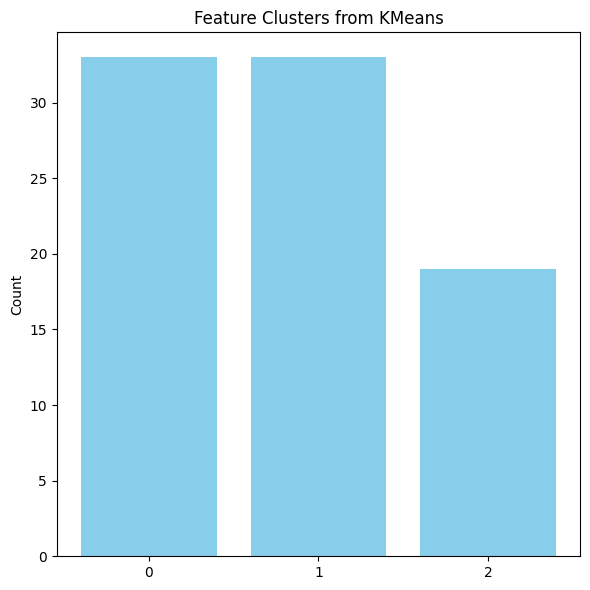

In [ ]:
import data_analysis.data_processing as da
import learning.data_learning as dl

# reload module to bypass caching
import importlib
importlib.reload(da)

# treat it as a long path to avoid path length issues
test_window_path = da.Path(r'\\?\\')
test_window = da.ThirtySecWindow(test_window_path)
test_data_set_path = da.Path(r'\\?\C:\Users\jannis\Documents\HSP_IDS\Material\Aktuell\2025-02-17_11-14-33_192.168.1.0-normal_1')

da.connection_kmeans(test_window)